In [17]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [18]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\osaz001\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [19]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [20]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [21]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [22]:
# load all models
%reload_ext autoreload
%autoreload 2
"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



c:\appl\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5109 - loss: 0.2499 - val_accuracy: 0.5312 - val_loss: 0.2485
Epoch 2/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.5292 - loss: 0.2487 - val_accuracy: 0.5375 - val_loss: 0.2479
Epoch 3/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.5372 - loss: 0.2478 - val_accuracy: 0.5471 - val_loss: 0.2468
Epoch 4/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.5459 - loss: 0.2466 - val_accuracy: 0.5536 - val_loss: 0.2458
Epoch 5/5
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.5502 - loss: 0.2461 - val_accuracy: 0.5601 - val_loss: 0.2441
Restoring model weights from the end of the best epoch: 5.
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_lea

In [23]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5101649917581148
Confusion Matrix:
[[59650 39622]
 [55767 39698]]
Precision: 50.047907211296014
Recall: 41

In [24]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [25]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [26]:


"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)"""


"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):\n\n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        \n        # Normalization factor to ensure absolute sum of values is 1\n        num_assets = len(assets)\n        if num_assets > 0:\n            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets\n\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\n\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test

In [27]:
import pandas as pd
import numpy as np
"""def update_df_with_asset_performance(signals_df, portfolio_df, target_days, returns_df, target_volatility=0.10):
    # Calculate volatilities using the existing function for annualized volatility
    volatilities = calculate_annualized_volatility(returns_df.fillna(0))
    
    # Ensure portfolio DataFrame columns are of float type to avoid dtype issues when updating
    portfolio_df = portfolio_df.astype(float)
    
    # Iterate over each date in the signals DataFrame
    for date_str, row in signals_df.iterrows():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=target_days - 1)  # Hold for target_days
        # Filter for assets with non-zero values (either 1 or -1)
        assets = row[row != 0].index.tolist()
        asset_signals = row[row != 0].values  # Get the signals (1 or -1)
        if not assets:
            continue  # Skip if no assets are to be traded on this date

        if start_date in volatilities.index:
            # Asset vol on start date for buying or shorting assets
            asset_vols = volatilities.loc[start_date, assets]
            weights = 1 / asset_vols
            normalized_weights = weights / weights.sum()  # Normalize weights
            
            adjusted_weights = normalized_weights * asset_signals  # Apply signals (-1 for short, 1 for long)
            # Get past returns for the assets
            past_returns = returns_df.loc[start_date - pd.DateOffset(days=target_days):start_date, assets]

            # Calculate portfolio volatility and determine leverage factors    
            port_vol = calculate_portfolio_volatility(adjusted_weights, past_returns)
            leverage = determine_leverage_factors(port_vol, target_volatility)
            adjusted_weights *= leverage  # Apply leverage factor

            # Update the portfolio DataFrame for the holding period
            portfolio_df.loc[start_date:end_date, assets] = adjusted_weights.values
    
    return portfolio_df
            



signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    # Update model DataFrame
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)"""


"def update_df_with_asset_performance(signals_df, portfolio_df, target_days, returns_df, target_volatility=0.10):\n    # Calculate volatilities using the existing function for annualized volatility\n    volatilities = calculate_annualized_volatility(returns_df.fillna(0))\n    \n    # Ensure portfolio DataFrame columns are of float type to avoid dtype issues when updating\n    portfolio_df = portfolio_df.astype(float)\n    \n    # Iterate over each date in the signals DataFrame\n    for date_str, row in signals_df.iterrows():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=target_days - 1)  # Hold for target_days\n        # Filter for assets with non-zero values (either 1 or -1)\n        assets = row[row != 0].index.tolist()\n        asset_signals = row[row != 0].values  # Get the signals (1 or -1)\n        if not assets:\n            continue  # Skip if no assets are to be 

In [28]:
%reload_ext autoreload
%autoreload 2

signals_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

portfolio_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}

for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 
    assets_df = pd.concat([best_assets, worst_assets])
    assets_df['update_value'] = 0
    assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
    assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

    pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
    signals_dfs[name].update(pivot_df)

    portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
leverage 1.1269933168138095
leverage 6.657275868991886
leverage 6.023245944331041
leverage 11.992682264277473
leverage 5.471887209187787
leverage 2.3483910831190262
leverage 9.894237281619425
leverage 7.592668369167777
leverage 13.972972256903573
leverage 4.752446546126798
leverage 11.965762989219746
leverage 3.235434619567302
leverage 3.144255945633182
leverage 4.663875197309106
leverage 3.399659734760861
leverage 1.2407952323000861
leverage 3.418100615456022
leverage 2.783663463014181
leverage 4.1522707584264085
leverage 7.398257877413919
leverage 2.422444473305843
leverage 2.090654493959676
leverage 3.4772086892307055
leverage 6.717748873812829
leverage 4.470431344060509
leverage 13.262027471356806
leverage 17.722463116063704
leverage 5.508041395790551
leverage 9.085575831270086
leverage 12.250554735971168
leverage 4.928190448006692
leverage 12.3871740111

In [29]:
xgb_weights = portfolio_dfs['xgb']
lgb_weights = portfolio_dfs['lgb']
ridge_weights = portfolio_dfs['ridge']
NN_weights = portfolio_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)

In [30]:
#xgb_trade_volume.sum()

xgb_weights.tail(1)

,EQ_0,EQ_1,EQ_2,EQ_3,EQ_4,EQ_5,EQ_6,EQ_7,EQ_8,EQ_9,EQ_10,EQ_11,EQ_12,EQ_13,EQ_14,EQ_15,EQ_16,EQS_0,EQS_1,EQS_2,EQS_3,EQS_4,EQS_5,EQS_6,EQS_7,EQS_8,EQS_9,EQS_10,FI_0,FI_1,FI_2,FI_3,FI_4,FI_5,FI_6,FI_7,FI_8,FI_9,FI_10,FI_11,FI_12,FI_13,FI_14,FXD_0,FXD_1,FXD_2,FXD_3,FXD_4,FXD_5,FXD_6,FXD_7,FXD_8,FXD_9,FXE_0,FXE_1,FXE_2,FXE_3,FXE_4,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7
todate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278811,0.0,0.0,0.0,0.0,0.0,0.0,-2.079892,-0.623729,0.0,0.334651,-1.016556,0.0,-0.734164,0.0,-1.435082,0.0,0.0,0.340037,0.0,0.372668,0.0,0.0,0.0,0.470149,0.0,0.0,0.0,0.0,0.0,-0.420118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


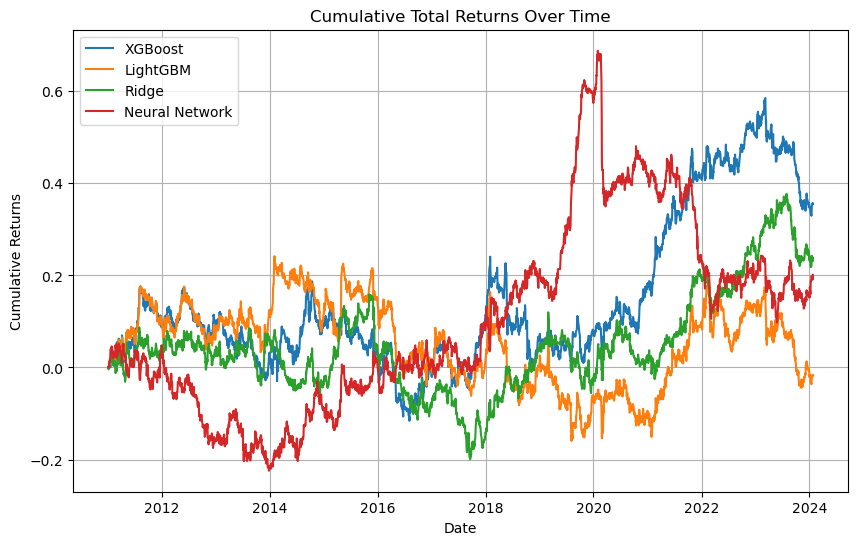

In [31]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
#xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
#lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
#ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
#NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# use cumsum 
xgb_cumulative_total_returns = xgb_total_returns.cumsum()
lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [32]:
xgb_total_returns.tail(125)

todate
2023-07-31    0.000120
2023-08-01   -0.004114
2023-08-02   -0.005194
2023-08-03   -0.003614
2023-08-04   -0.000271
2023-08-07   -0.002394
2023-08-08   -0.003086
2023-08-09    0.006003
2023-08-10   -0.006119
2023-08-11   -0.003004
2023-08-14    0.008042
2023-08-15    0.004151
2023-08-16    0.003717
2023-08-17    0.000995
2023-08-18   -0.002467
2023-08-21   -0.004509
2023-08-22    0.001781
2023-08-23   -0.004677
2023-08-24   -0.003765
2023-08-25    0.005103
2023-08-28    0.000664
2023-08-29   -0.003877
2023-08-30    0.001470
2023-08-31   -0.005226
2023-09-01   -0.006761
2023-09-04    0.001866
2023-09-05    0.003129
2023-09-06   -0.002492
2023-09-07    0.006260
2023-09-08    0.001297
2023-09-11   -0.000155
2023-09-12   -0.003641
2023-09-13    0.008645
2023-09-14    0.014150
2023-09-15   -0.002046
2023-09-18   -0.004619
2023-09-19   -0.005355
2023-09-20   -0.015480
2023-09-21   -0.009879
2023-09-22   -0.002598
2023-09-25   -0.006184
2023-09-26   -0.001085
2023-09-27   -0.002697
2023

In [33]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
6399


LightGBM trade volume:
6378


Ridge trade volume:
6839


Neural Network trade volume:
6347




In [34]:
ridge_metrics = financial_metrics(ridge_total_returns)
lgb_metrics = financial_metrics(lgb_total_returns)
xgb_metrics = financial_metrics(xgb_total_returns)
NN_metrics = financial_metrics(NN_total_returns)
metrics = {
    "Ridge": ridge_metrics,
    "LightGBM": lgb_metrics,
    "XGBoost": xgb_metrics,
    "Neural Network": NN_metrics
}

metrics_df = pd.DataFrame(metrics).T  # Transpose to get models as rows and metrics as columns
# Optionally, reset the index to have model names as a separate column


In [35]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Sharpe Ratio,Max Drawdown,Volatility,Calmar Ratio,Skewness,Kurtosis
Ridge,0.017387,0.108655,0.160018,-2.483780,0.108655,0.007000,-0.165429,2.979363
LightGBM,-0.001228,0.121544,-0.010106,-1.811819,0.121544,-0.000678,-0.152269,5.223286
XGBoost,0.026666,0.119406,0.223324,-1.760707,0.119406,0.015145,-0.486062,5.490936
Neural Network,0.015114,0.124916,0.120992,-5.151738,0.124916,0.002934,-0.427744,9.021861


In [36]:
df_ranks = add_features(df_read, [63, 126, 252])

#only keep columns with "momentum"
X_ranked = df_ranks.filter(regex='momentum')

X_ranked_trans = transform_and_pivot_df(X_ranked, date_col)

columns_to_rank = X_ranked_trans.filter(regex='momentum').columns

for col in columns_to_rank:
    X_ranked_trans[col + '_rank'] = X_ranked_trans[col].rank(method='average')

# Calculate the mean of ranks across specified columns
rank_columns = [col + '_rank' for col in columns_to_rank]
X_ranked_trans['mean_rank'] = X_ranked_trans[rank_columns].mean(axis=1)

# Merge the rank data with additional data such as 'asset' and 'todate'
a = X_ranked_trans.index
b = df_ranks.index.intersection(a)
c = df_ranks.loc[b, ['asset', 'todate']]
d = X_ranked_trans[['mean_rank']].join(c)

# Calculate the top and bottom percentiles for the mean rank
e_top = d.groupby('todate')['mean_rank'].apply(lambda x: np.percentile(x, 0.9))
e_bottom = d.groupby('todate')['mean_rank'].apply(lambda x: np.percentile(x, 0.1))

# Convert to DataFrame and merge thresholds back with the ranked data
e_top_df = e_top.reset_index()
e_top_df.columns = ['todate', 'top_threshold']
e_bottom_df = e_bottom.reset_index()
e_bottom_df.columns = ['todate', 'bottom_threshold']

d_merged = d.merge(e_top_df, on='todate').merge(e_bottom_df, on='todate')

# Select top and bottom assets based on thresholds
top_assets = d_merged[d_merged['mean_rank'] >= d_merged['top_threshold']]
bottom_assets = d_merged[d_merged['mean_rank'] <= d_merged['bottom_threshold']]

KeyError: "None of [Index(['asset', 'todate'], dtype='object')] are in the [columns]"

In [37]:
import pandas as pd
import numpy as np

df_ranks = add_features(df_read, [63, 126, 252])

#only keep columns with "momentum"
X_ranked = df_ranks.filter(regex='momentum')

X_ranked_trans = transform_and_pivot_df(X_ranked, date_col)
columns_to_rank = X_ranked_trans.filter(regex='momentum').columns

for col in columns_to_rank:
    X_ranked_trans[col + '_rank'] = X_ranked_trans[col].rank(method='average')

In [38]:

X_ranked_trans['mean_rank'] = X_ranked_trans[columns_to_rank + '_rank'].mean(axis=1)